## Light Curve Analysis 

Star and planet like HD209458b

- M_star = 1.148 M_sun
- R_star = 1.203 R_sun
- M_planet = 0.69 M_jup
- R_planet = 1.38 R_jup
- Period = 3.52472 JD
- a = 0.04747 au
- Inclination = 86.59 
- Eccentricity = 0.0082
- Limb darkening = [0.5, 0.2] # need reference

In [1]:
%pylab inline 

import math as mt
import pyfits as pf
import seaborn as sb
import pandas as pd

from os.path import join

from pytransit.orbits_f import orbits as of
from pytransit import MandelAgol as MA

from exotk.de import DiffEvol
from exotk.priors import PriorSet, UP, NP, JP
from exotk.utils.orbits import as_from_rhop
from exotk.utils.likelihood import ll_normal_es

from emcee import EnsembleSampler
cp = sb.color_palette()

random.seed(0)

Populating the interactive namespace from numpy and matplotlib


### Generate transit data + white noise

In [2]:
import batman #install batman-package (Bad-Ass Transit Model cAlculatioN)
import astropy.units as u
from astropy.constants import G, R_sun, M_sun, R_jup, M_jup

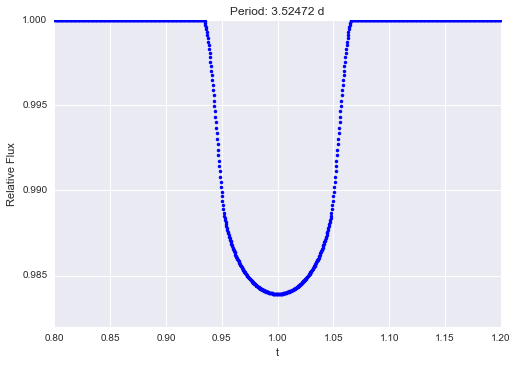

In [3]:
R_planet = 1.38*R_jup
M_planet = 0.69*M_jup
R_star = 1.203*R_sun
M_star = 1.148*M_sun

params = batman.TransitParams() # object to store the transit parameters
params.t0 = 1.0 # time of inferior conjunction 
params.per = 3.52472  # orbital period (days)
params.rp = R_planet/R_star # planet radius (in units of stellar radii)

# calculate semi-major axis from orbital period value
a = (((params.per*u.day)**2 * G * (M_star + M_planet) / (4*np.pi**2))**(1./3)).to(R_star).value

params.a = a # semi-major axis (in units of stellar radii)
params.inc = 86.59 # orbital inclination (in degrees)
params.ecc = 0.0 # eccentricity
params.w = 90. # longitude of periastron (in degrees), 90 for circular
params.u = [0.5, 0.2] # limb darkening coefficients
params.limb_dark = "quadratic" # limb darkening model

t = np.linspace(0.8, 1.2, 1000) # times at which to calculate the light curve
m = batman.TransitModel(params, t) # initializes the model
f_true = m.light_curve(params)

plt.plot(t, f_true, 'b.')
plt.title("Period: {0} d".format(params.per))
plt.xlabel("t")
plt.ylabel("Relative Flux")

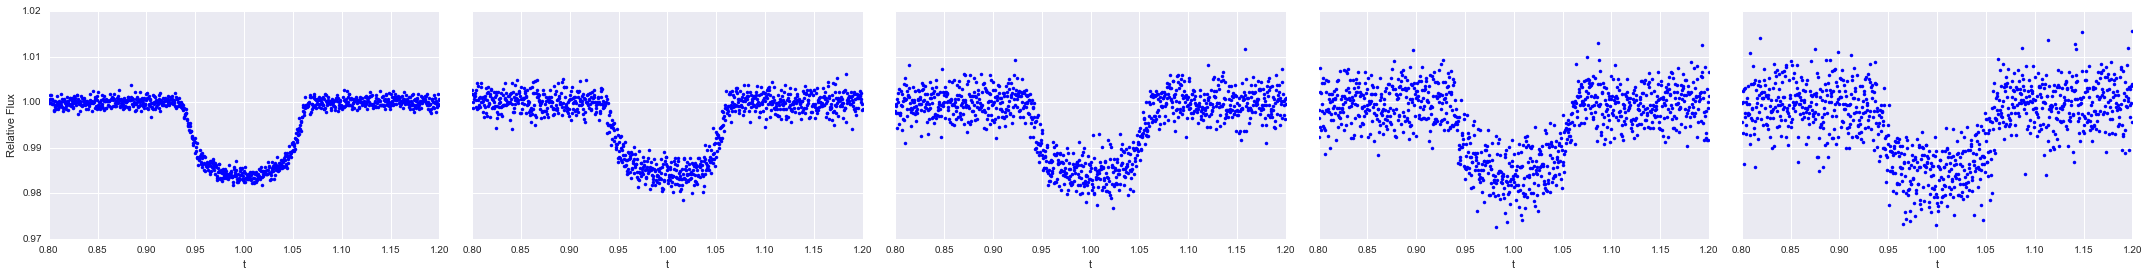

In [4]:
# add gaussian error 
rs = np.random.RandomState(seed=42)

sigma = [0.001, 0.002, 0.003, 0.004, 0.005]

fig, axs = subplots(1,len(sigma), figsize=(30,4), sharey=True)
for i in range(len(sigma)):
    errors = sigma[i]*np.ones_like(f_true) # sigma
    f = f_true + errors*rs.randn(len(t))

    axs[i].plot(t, f, 'b.')
    axs[i].set_xlabel("t")
    
axs[0].set_ylabel("Relative Flux")
fig.tight_layout()

#### Choose one set

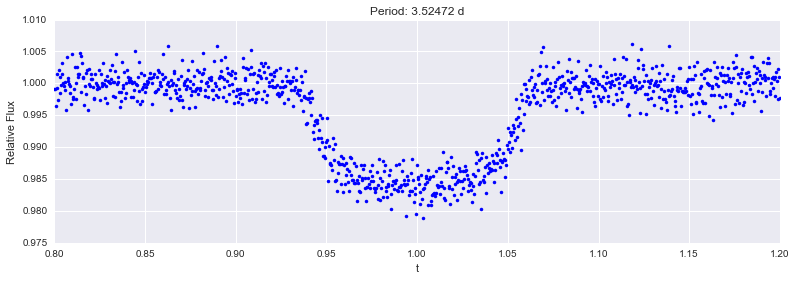

In [5]:
std = 0.002
errors = std*np.ones_like(f_true) # sigma
f = f_true + errors*rs.randn(len(t))

fig, ax = subplots(1, 1, figsize=(13, 4))
ax.plot(t, f, 'b.')
ax.set_title("Period: {0} d".format(params.per))
ax.set_xlabel("t")
ax.set_ylabel("Relative Flux")

#### Model parameters

In [6]:
print 'Orbital Period = ', params.per
density_true = M_star/(4./3.*pi*R_star**3)*0.001
print 'Star Density = ', density_true.value
print 'Ratio of radius = ', params.rp
k2_true = params.rp**2
print 'Ration of area = ', k2_true
print 'White noise std = ', std
b_true = params.a*cos(params.inc*pi/180)
print 'Impact parameter = ', b_true
print 'Limb darkening = ', params.u
q1_true = (params.u[0] + params.u[1])**2
q2_true = 0.5*params.u[0]/(params.u[0] + params.u[1])
print 'q1 = ', q1_true
print 'q2 = ', q2_true

Orbital Period =  3.52472
Star Density =  0.930693379995
Ratio of radius =  0.117914924152
Ration of area =  0.0139039293378
White noise std =  0.002
Impact parameter =  0.50487945746
Limb darkening =  [0.5, 0.2]
q1 =  0.49
q2 =  0.357142857143


### Log Posterior Function

In [7]:
class LPFunction(object):
    """A simple log posterior function class.
    """
    def __init__(self, time, flux, nthreads=2):
        self.tm = MA(lerp=True, klims=(0.08,0.13), nthr=nthreads) 
        self.nthr = nthreads

        self.time     = time.copy()
        self.flux_o   = flux.copy()
        self.npt      = flux.size
        self._wrk_lc  = zeros_like(time)  # These two work arrays are actually rather pointless
        self._wrk_ld  = zeros(2)          #
        
        self.priors = [NP(   1.0,   0.01,  'tc'), ##  0  - Transit centre
                       NP(  3.52,   0.02,   'p'), ##  1  - Period
                       JP( 0.012,  0.016,  'k2'), ##  2  - planet-star area ratio
                       NP(  0.93,    0.1, 'rho'), ##  3  - Stellar density in gr/cm^3
                       UP(     0,   0.99,   'b'), ##  4  - Impact parameter
                       UP(  1e-3,   5e-3,   'e'), ##  5  - White noise std
                       NP(   1.0,  0.002,   'c'), ##  6  - Baseline constant
                       UP(     0,    1.0,  'q1'), ##  7  - limb darkening q1
                       UP(     0,    1.0,  'q2')] ##  8  - limb darkening q2
        self.ps = PriorSet(self.priors)
        
        
    def compute_baseline(self, pv):
        """Simple constant baseline model"""
        self._wrk_lc.fill(pv[6])
        return self._wrk_lc

    
    def compute_transit(self, pv):
        """Transit model"""
        _a  = as_from_rhop(pv[3], pv[1])  # Scaled semi-major axis from stellar density and orbital period
        _i  = mt.acos(pv[4]/_a)           # Inclination from impact parameter and semi-major axis
        _k  = mt.sqrt(pv[2])              # Radius ratio from area ratio
        
        a,b = mt.sqrt(pv[7]), 2*pv[8]
        self._wrk_ld[:] = a*b, a*(1.-b)   # Quadratic limb darkening coefficients
        
        return self.tm.evaluate(self.time, _k, self._wrk_ld, pv[0], pv[1], _a, _i)

    
    def compute_lc_model(self, pv):
        """Combined baseline and transit model"""
        return self.compute_baseline(pv) * self.compute_transit(pv)


    def __call__(self, pv):
        """Log posterior density"""
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -inf
        flux_m = self.compute_lc_model(pv)
        return self.ps.c_log_prior(pv) + ll_normal_es(self.flux_o, flux_m, pv[5])

### Basic parameter estimation

Generate parameter vector population clumped around the posterior maxima using Differential Evolution

In [8]:
npop, de_iter, mc_iter = 100, 200, 15000 # nwalkers, de_iteration_number, mcmc_iteration

lpf = LPFunction(t, f)

de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)

In [9]:
de.optimize(de_iter)

(array([  9.99539702e-01,   3.52003261e+00,   1.36549276e-02,
          9.11437663e-01,   4.98846890e-01,   2.00752750e-03,
          9.99909447e-01,   7.01783015e-01,   1.69289901e-01]),
 -4815.1432274123372)

In [10]:
print lpf.ps.bounds
# print mean(lpf.ps.bounds, 1)
# print (lpf.ps.pmaxs - lpf.ps.pmins)/2.

[[  9.50000000e-01   1.05000000e+00]
 [  3.42000000e+00   3.62000000e+00]
 [  1.20000000e-02   1.60000000e-02]
 [  4.30000000e-01   1.43000000e+00]
 [  0.00000000e+00   9.90000000e-01]
 [  1.00000000e-03   5.00000000e-03]
 [  9.90000000e-01   1.01000000e+00]
 [  0.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]]


### Run MCMC

In [11]:
sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf) # init sampler (nwalkers, ndim, lnprob posterior)

In [12]:
# theta0 = mean(lpf.ps.bounds, 1)
# std =(lpf.ps.pmaxs - lpf.ps.pmins)/2
# starting_guess = np.zeros((npop, lpf.ps.ndim))
# starting_guess = np.random.normal(theta0, std, (npop, lpf.ps.ndim))

sampler.run_mcmc(de.population, mc_iter); # run mcmc (starting guess, number of step)

#### Overview

The MCMC chains are now stored in sampler.chain. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

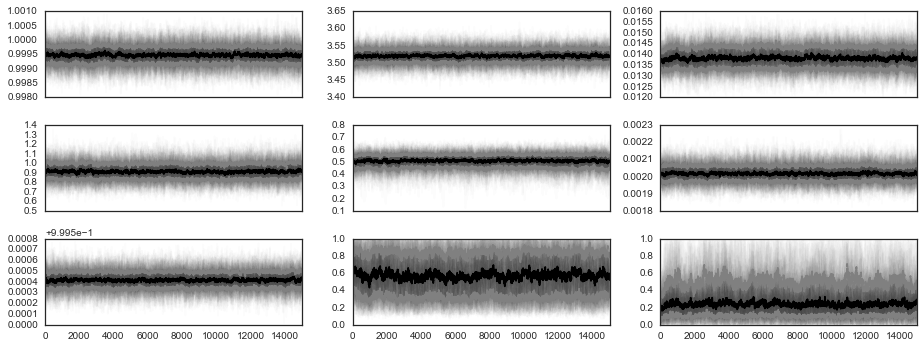

In [13]:
with sb.axes_style('white'):
    fig, axs = subplots(3,3, figsize=(13,5), sharex=True)
    ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    percs = [percentile(sampler.chain[:,:,i], [50,16,84], 0) for i in range(9)]
    [axs.flat[i].plot(sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(9)]
    [[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(9)]
    setp(axs, xlim=[0,mc_iter])
    fig.tight_layout()

Good, they don't show any significant long-term trends. We can decide a suitable *burning factor* (due to initial guess).

Look the mean autocorrelation length for each parameter in order to decide a suitable MCMC chain *thinning factor* (because the consecutive MCMC samples are correlated)

In [14]:
sampler.acor.astype(np.int)

array([67, 66, 77, 68, 72, 65, 66, 78, 81])

#### Burn-it all baby

In [15]:
burn = 10000
thin = 68
walkers = sampler.chain[:, burn::thin, :]
samples = walkers.reshape((-1, lpf.ps.ndim)) #nsamples, n_parameter

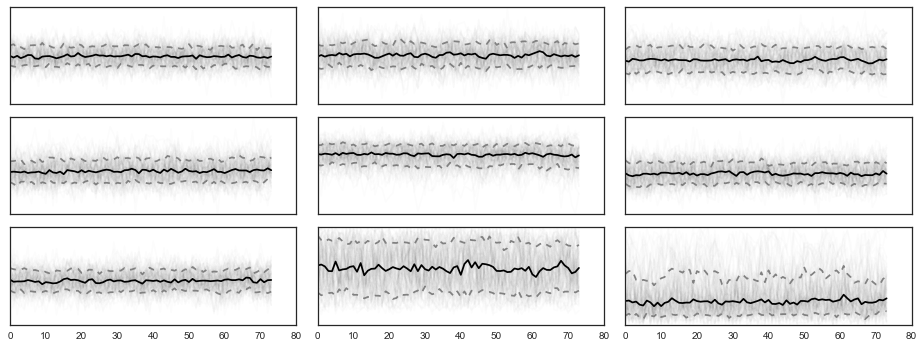

In [16]:
with sb.axes_style('white'):
    fig, axs = subplots(3,3, figsize=(13,5), sharex=True)
    ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    percs = [percentile(walkers[:,:,i], [50,16,84], 0) for i in range(9)]
    [axs.flat[i].plot(walkers[:,:,i].T, 'k', alpha=0.01) for i in range(9)]
    [[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(9)]
    setp(axs, yticks=[])
    fig.tight_layout()

### Analyze the Result

In [17]:
import corner

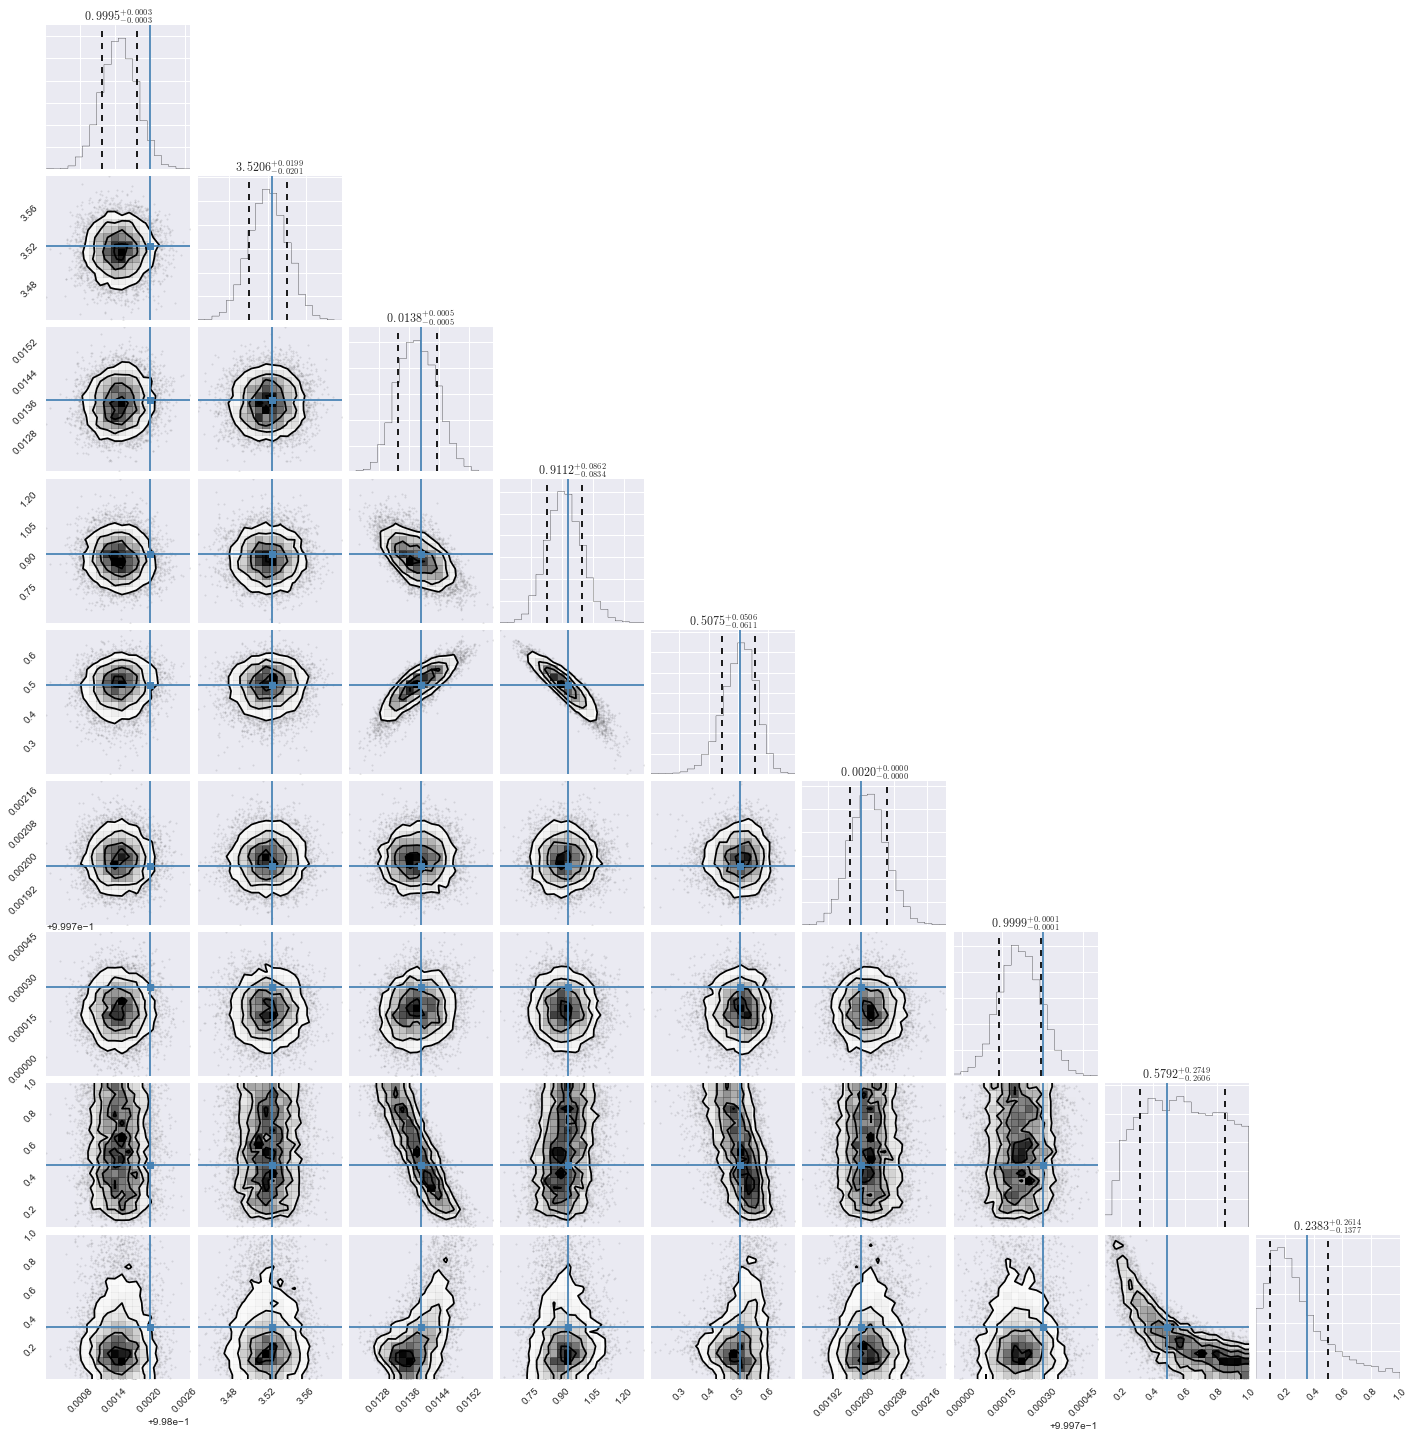

In [18]:
fig = corner.corner(samples, quantiles=(0.16, 0.84), show_titles=True, title_fmt='.4f', \
                    truths=[params.t0, params.per, k2_true, density_true.value, b_true, std, 1.0, q1_true, q2_true], \
                    title_kwargs={"fontsize": 12})

#### Quantile of parameters, median $\pm '1 \sigma'$

In [19]:
pars = lpf.ps.names
theta = np.zeros(27).reshape((9,3)) 
for i in range(9):
    theta[i,:] = corner.quantile(samples[:,i], [0.16, 0.5, 0.84]) # median = theta[:,1]
    print pars[i], "\t = ", theta[i,1], "\t +- ", [theta[i,2]-theta[i,1], theta[i,0]-theta[i,1]]

tc 	 =  0.999470624903 	 +-  [0.00029989162357302313, -0.00030306326034079678]
p 	 =  3.52056469851 	 +-  [0.019864755679816604, -0.020083841527883894]
k2 	 =  0.0138059152592 	 +-  [0.00054120101678219353, -0.0005102132206429872]
rho 	 =  0.911183116635 	 +-  [0.086183581233029494, -0.083437553780496443]
b 	 =  0.507515891252 	 +-  [0.050616115735272915, -0.061060090450743898]
e 	 =  0.00201725121277 	 +-  [4.5487294169373627e-05, -4.3879613029581231e-05]
c 	 =  0.999915553044 	 +-  [7.8318830206036694e-05, -7.7610543135375742e-05]
q1 	 =  0.579180620827 	 +-  [0.27488000092381593, -0.26061589507859673]
q2 	 =  0.238314438195 	 +-  [0.26135707922428841, -0.13771298100633775]


In [20]:
mp = theta[:,1] # median of parameters

In [21]:
# compute the light curve using first 1000 derived parameters
flux_pr = array([lpf.compute_lc_model(pv) for pv in samples[permutation(samples.shape[0])[:1000]]]) 

# flux percentile
flux_pc = array(percentile(flux_pr, [50, 0.15, 99.85, 2.5, 97.5, 16, 84], 0))

### Overplot the result with data

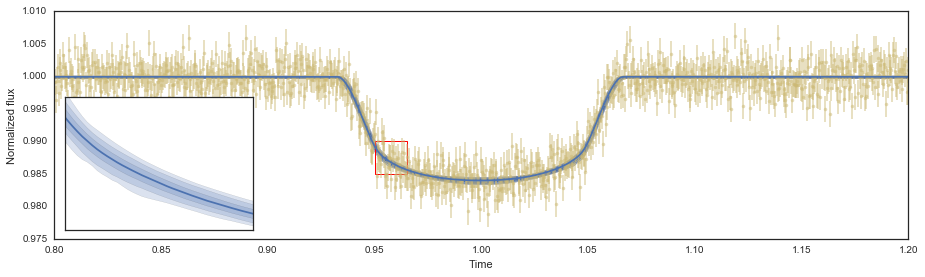

In [22]:
with sb.axes_style('white'):
    zx1,zx2,zy1,zy2 = 0.95, 0.965, 0.985, 0.99
    fig, ax = subplots(1,1, figsize=(13,4))
    cp = sb.color_palette()
    
    # data with errorbar from calculation
    ax.errorbar(lpf.time, lpf.flux_o, mp[5], fmt='.', c=cp[4], alpha=0.5) 
    
    # combination from other percentile
    [ax.fill_between(lpf.time,*flux_pc[i:i+2,:], alpha=0.5, facecolor=cp[0]) for i in range(1,6,2)] 
    
    # median (center line)
    ax.plot(lpf.time, flux_pc[0], c=cp[0]) 
    
    setp(ax, xlim=lpf.time[[0,-1]], xlabel='Time', ylabel='Normalized flux')
    fig.tight_layout()
    
    # add new window for zoom
    az = fig.add_axes([0.075,0.18,0.20,0.46]) #location
    ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='r',lw=1))
    [az.fill_between(lpf.time,*flux_pc[i:i+2,:],alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
    az.plot(lpf.time, flux_pc[0], c=cp[0]) #median
    setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])

### Add to Pandas DataFrame

In [23]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=samples.copy(), columns=lpf.ps.names)

df['e'] *= 1e6 # stdev data (white noise)
df['k'] = sqrt(df.k2) # radius ratio

# Limb darkening coefs
df['u'] = 2*sqrt(df.q1)*df.q2 # Kipping (2013, MNRAS, 435(3), 2152–2160)
df['v'] = sqrt(df.q1)*(1-2*df.q2) 

df = df.drop('k2', axis=1)

df.describe()

,tc,p,rho,b,e,c,q1,q2,k,u,v
count,7400.0000,7400.0000,7400.0000,7400.0000,7400.0000,7.4000e+03,7400.0000,7400.0000,7400.0000,7400.0000,7400.0000
mean,0.9995,3.5204,0.9133,0.5027,2017.8999,9.9992e-01,0.5828,0.2917,0.1175,0.3803,0.3660
std,0.0003,0.0200,0.0849,0.0576,44.9417,7.7938e-05,0.2329,0.2104,0.0022,0.1963,0.3239
min,0.9982,3.4466,0.6007,0.2035,1856.6519,9.9967e-01,0.0995,0.0003,0.1096,0.0005,-0.5539
25%,0.9993,3.5070,0.8552,0.4670,1987.0030,9.9986e-01,0.3895,0.1381,0.1160,0.2328,0.1382
50%,0.9995,3.5206,0.9112,0.5075,2017.2512,9.9992e-01,0.5792,0.2383,0.1175,0.3702,0.4064
75%,0.9997,3.5340,0.9694,0.5433,2047.4853,9.9997e-01,0.7803,0.3926,0.1191,0.5163,0.6221
max,1.0007,3.5974,1.2961,0.6942,2207.5357,1.0002e+00,1.0000,0.9993,0.1258,1.1496,0.9886


#### Add Violinplot

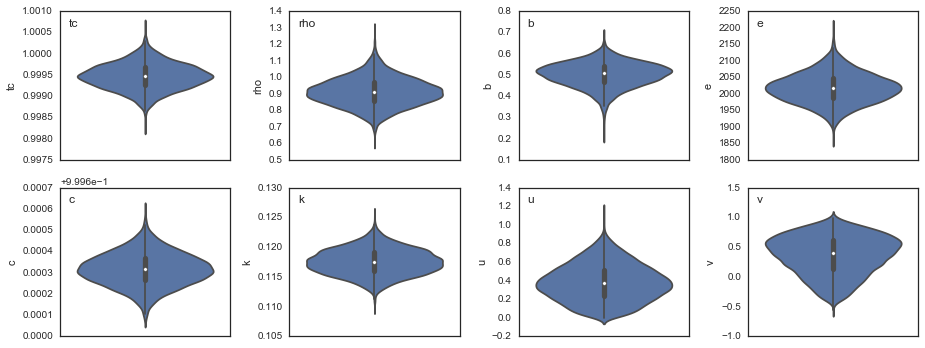

In [24]:
with sb.axes_style('white'):
    fig, axs = subplots(2,4, figsize=(13,5))
    pars = 'tc rho b e c k u v'.split()
    [sb.violinplot(y=df[p], ax=axs.flat[i]) for i,p in enumerate(pars)]
    [axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
    setp(axs)
    fig.tight_layout()

### Check correlation plot of some parameters

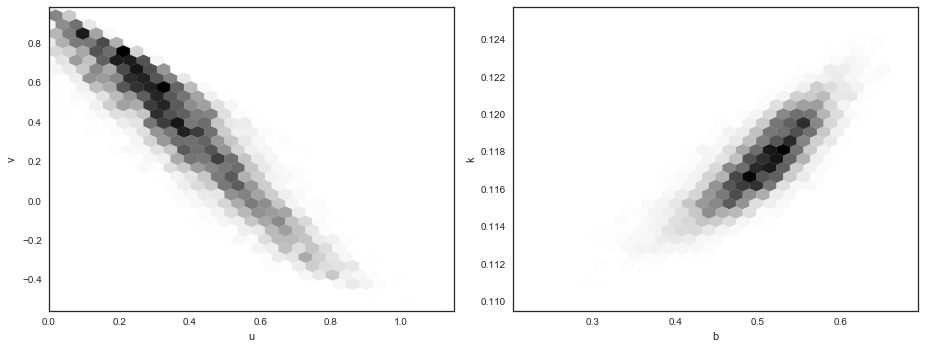

In [25]:
with sb.axes_style('white'):
    fig, axs = subplots(1,2, figsize=(13,5))
    cpars = dict(gridsize=30)
    axs[0].hexbin(df.u,df.v, **cpars)
    axs[1].hexbin(df.b,df.k, **cpars)
    setp(axs[0], xlabel='u', ylabel='v') # correlation of limb darkening coef 
    setp(axs[1], xlabel='b', ylabel='k') # impact parameter and radius ratio
    fig.tight_layout()